In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade keras

In [ ]:
import string
import numpy as np
from pickle import dump, load
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.applications.xception import Xception, preprocess_input
from keras.api.preprocessing.image import load_img, img_to_array
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
from keras.api.utils import to_categorical, get_file
from keras.api.models import Model, load_model
from keras.api.layers import add, Input, Dense, LSTM, Embedding, Dropout
from PIL import Image
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

### Read File

In [ ]:
def load_file(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

### Load and organize image captions from a file into a dictionary mapping image names to their corresponding caption lists.

In [ ]:
def load_all_image_captions(filename):
  file = load_file(filename)
  captions = file.split('\n');
  descriptions = {}
  for caption in captions[:-1]:
    img, caption = caption.split('\t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [caption]
    else:
      descriptions[img[:-2]].append(caption)
  return descriptions

### Clean and preprocess captions by removing punctuation, converting to lowercase, and filtering out short or non-alphabetic words.

In [ ]:
def cleaning_text(captions):
  table = str.maketrans('', '', string.punctuation)
  for img, caps in captions.items():
    for i, img_caption in enumerate(caps):
      img_caption.replace("-", "")
      desc = img_caption.split()
      desc = [word.lower() for word in desc]
      desc = [word.translate(word) for word in desc]
      desc = [word for word in desc if len(word) > 1]
      desc = [word for word in desc if word.isalpha()]
      img_caption = ' '.join(desc)
      captions[img][i] = img_caption
  return captions

### Create a vocabulary set from all words in the provided image descriptions.

In [ ]:
def text_vocabulary(descriptions):
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

### Save image descriptions to a file, with each line formatted as 'image_name\tcaption'

In [ ]:
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/thesis')

In [ ]:
!ls

Flicker8k_Dataset  Flickr8k_text


### Loading captions from Flickr8k.token.txt into a dictionary

In [ ]:
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"

filename = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = load_all_image_captions(filename)
print("Length of descriptions = ", len(descriptions))

clean_descriptions = cleaning_text(descriptions)

vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions =  8092
Length of vocabulary =  8357


### Download the model

In [ ]:
def download_with_retry(url, filename, max_retries = 3):
  for attempt in range(max_retries):
    try:
      return get_file(filename, url)
    except Exception as e:
      if attempt == max_retries - 1:
        raise e
      print("Download failed")

In [ ]:
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, "xception_weights.h5")
model = Xception(include_top = False, pooling = 'avg', weights = 'imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Extract image features using a pre-trained model and store them in a dictionary

In [ ]:
def extract_features(directory):
  features = {}
  valid_images = ['.jpg', '.jpeg', '.png']
  for img in tqdm(os.listdir(directory)):
    ext = os.path.splitext(img)[1].lower()
    if ext not in valid_images:
      continue
    filename = directory + "/" + img
    image = Image.open(filename)
    image = image.resize((299, 299))
    image = np.expand_dims(image, axis = 0)
    image = image / 127.5
    image = image - 1.0

    feture = model.predict(image)
    features[img] = feture
  return features

In [ ]:
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

  0%|          | 0/8101 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━

In [ ]:
features = load(open("features.p", "rb"))

### ### Load and filter photo filenames from a file, returning only those present in the dataset directory.

In [ ]:
def load_photos(filename):
  file = load_file(filename)
  photos = file.split("\n")[:-1]
  photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))]
  return photos_present

In [ ]:
def load_clean_descriptions(filename, photos):
  file = load_file(filename)
  descriptions = {}
  for line in file.split("\n"):
    words = line.split()
    if len(words) < 1:
      continue
    image, image_caption = words[0], words[1:]
    if image in photos:
      if image not in descriptions:
        descriptions[image] = []
      desc = '<start> ' + " ".join(image_caption) + ' <end>'
      descriptions[image].append(desc)
  return descriptions

In [ ]:
def load_features(photos):
  all_features = load(open("features.p", "rb"))
  features = {k : all_features[k] for k in photos}
  return features

In [ ]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [ ]:
def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)

In [ ]:
dump(tokenizer, open('tokenizer.p', 'wb'))

In [ ]:
vocab_size =len(tokenizer.word_index) + 1
print(vocab_size)

7264


In [ ]:
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

In [ ]:
max_length = max_length(descriptions)
print(max_length)

31


In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = list(), list(), list()
  for desc in desc_list:
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
      out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
  def generator():
    while True:
      for key, desc_list in descriptions.items():

        feature = features[key][0]

        input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, desc_list, feature)

        for i in range(len(input_image)):
          yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]

  output_signature = ({
      'input_1': tf.TensorSpec(shape = (2048, ), dtype = tf.float32),
      'input_2': tf.TensorSpec(shape = (max_length, ), dtype = tf.int32)
  }, tf.TensorSpec(shape = (vocab_size, ), dtype = tf.int32))

  dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature = output_signature
  )
  return dataset.batch(32)

In [ ]:
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)

In [ ]:
for (a, b) in dataset.take(1):
  print(a['input_1'].shape, a['input_2'].shape, b.shape)

(32, 2048) (32, 31) (32, 7264)


In [ ]:
def define_model(vocab_size, max_length):
  inputs1 = Input(shape = (2048, ), name = 'input_1')
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation = 'relu')(fe1)

  inputs2 = Input(shape = (max_length, ), name = 'input_2')
  se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)

  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation = 'relu')(decoder1)
  outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

  model = Model(inputs = [inputs1, inputs2], outputs = outputs)

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

  print(model.summary())

  return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 31)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 31, 256)        │      1,859,584 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 2048)           │              0 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 31, 256)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 31)             │              0 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        524,544 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ dropout_5[0][0],       │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 256)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ add_26[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 7264)           │      1,866,848 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,842,080 (18.47 MB)

 Trainable params: 4,842,080 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:


epochs = 10

steps_per_epoch = 5

os.mkdir("models")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 31, 256)        │      1,859,584 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 31, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 31)             │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 7264)           │      1,866,848 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,842,080 (18.47 MB)

 Trainable params: 4,842,080 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

None


FileExistsError: [Errno 17] File exists: 'models'

In [ ]:
for i in range(epochs):
  dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
  model.fit(dataset, epochs = 1, verbose = 1)
  model.save("models/model_" + str(i) + ".h5")

  64048/Unknown 15728s 245ms/step - loss: 3.9762

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-a43c88f85570>", line 3, in <cell line: 0>
    model.fit(dataset, epochs = 1, verbose = 1)
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
    opt_outputs = multi_step_on_iterator(iterator)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_h

TypeError: object of type 'NoneType' has no len()

In [ ]:
model.save("models/overtrained_model.keras")


In [ ]:
epoch = 5
steps_per_epoch = len(train_descriptions) // 32
for i in range(epochs):
    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(dataset, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
    model.save(f"models/model_{i}.h5")


187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 265ms/step - loss: 3.1032


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - loss: 2.8117


187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - loss: 2.6374


187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - loss: 2.4503


187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - loss: 2.3082


187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - loss: 2.1642


187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - loss: 2.0452


187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - loss: 1.9384


187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - loss: 1.8344


187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - loss: 1.7426


In [ ]:
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="models/model_8.h5")
ap.add_argument("-p", "--pickle_path", required=True, help="tokenizer.p")

_StoreAction(option_strings=['-p', '--pickle_path'], dest='pickle_path', nargs=None, const=None, default=None, type=None, choices=None, required=True, help='tokenizer.p', metavar=None)

In [ ]:
def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")

  image = image.resize((299, 299))
  image = np.array(image)
  if image.shape[2] == 4:
    image = image[..., :3]
  image = np.expand_dims(image, axis = 0)
  image = image / 127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen = max_length)
    pred = model.predict([photo, sequence], verbose = 0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    in_text += " " + word
    if word == 'end':
      break
  return in_text

In [ ]:
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
vocab_size = len(tokenizer.word_index) + 1
model = define_model(vocab_size, max_length)
model.load_weights('models/model_8.h5')
xception_model = Xception(include_top = False, pooling = 'avg')

img_path = "Flicker8k_Dataset/3767841911_6678052eb6.jpg"
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 32, 256)        │      1,859,584 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 2048)           │              0 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 32, 256)        │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 32)             │              0 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │        524,544 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ dropout_8[0][0],       │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 256)            │              0 │ dense_10[0][0],        │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         65,792 │ add_27[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 7264)           │      1,866,848 │ dense_11[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,842,080 (18.47 MB)

 Trainable params: 4,842,080 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step



start little girl in blue shirt and blue shorts is running on the beach end


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


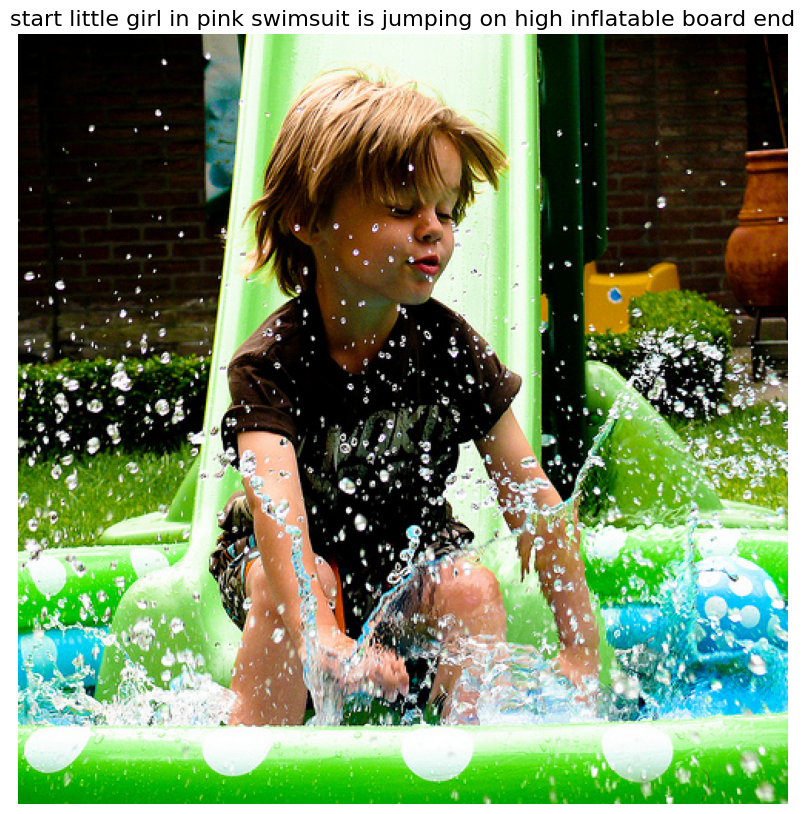

In [ ]:
img_path = "Flicker8k_Dataset/3758175529_81941e7cc9.jpg"
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

import matplotlib.pyplot as plt


description = generate_desc(model, tokenizer, photo, max_length)

plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(description, fontsize=16, wrap=True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


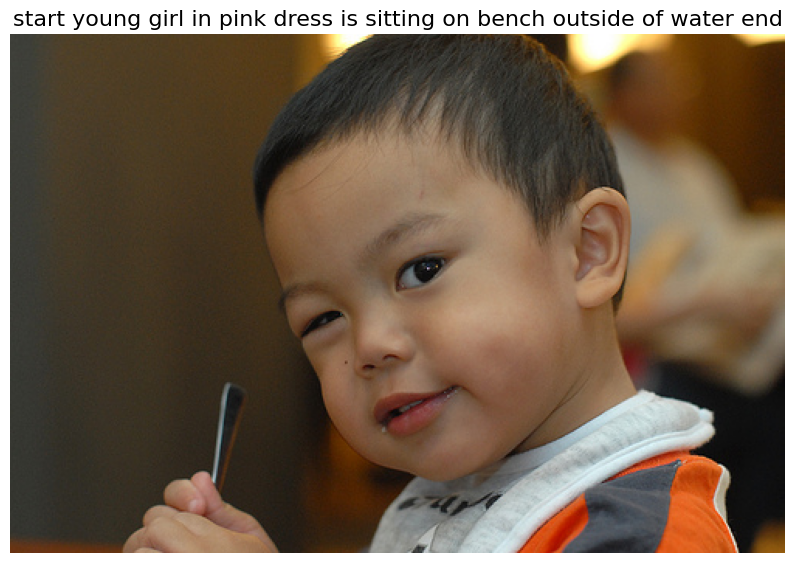

In [ ]:
img_path = "Flicker8k_Dataset/3757598567_739b7da835.jpg"
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

import matplotlib.pyplot as plt


description = generate_desc(model, tokenizer, photo, max_length)

plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(description, fontsize=16, wrap=True)
plt.show()


### Color is not recognized very well.

In [ ]:
def get_img_array(img_path, size):
    """
    Load and preprocess an image.
    """
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate a Grad-CAM heatmap given an image and model.
    """
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import cv2

In [ ]:
def overlay_heatmap(heatmap, img_path, alpha=0.3, colormap=cv2.COLORMAP_JET):
    """
    Overlay the Grad-CAM heatmap on the original image for better visualization.
    """
    heatmap = heatmap.numpy() if isinstance(heatmap, tf.Tensor) else heatmap

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, colormap)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img


In [ ]:
def generate_desc_with_steps(model, tokenizer, img_array, max_length):
    in_text = 'start'
    photo = xception_model.predict(img_array)
    caption_input = photo
    word_indices = []
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([caption_input, sequence], verbose=0)  # Adjust
        yhat_index = np.argmax(yhat)
        word_indices.append(yhat_index)
        word = word_for_id(yhat_index, tokenizer)
        if word is None or word == 'end':
            break
        in_text += ' ' + word
    return in_text, word_indices

In [ ]:
img_array = get_img_array(img_path, size=(299, 299))

In [ ]:
description, word_indices = generate_desc_with_steps(model, tokenizer, img_array, max_length)
print("Generated Caption:", description)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Generated Caption: start young girl in pink dress is sitting on bench outside of water


In [ ]:
last_conv_layer_name = 'block14_sepconv2_act'
heatmaps = []
for idx in word_indices:
    heatmap = make_gradcam_heatmap(
        img_array,
        xception_model,
        last_conv_layer_name,
        pred_index=idx
    )
    heatmaps.append(heatmap)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_308']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


In [ ]:
def make_gradcam_heatmap(img_array, encoder_model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=encoder_model.inputs,
        outputs=[encoder_model.get_layer(last_conv_layer_name).output, encoder_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    # Rest of the function remains the same...

def overlay_heatmap_on_word(heatmap, img_path, word, alpha=0.3):
    superimposed_img = overlay_heatmap(heatmap, img_path, alpha)
    plt.figure()
    plt.imshow(superimposed_img)
    plt.title(f"Word: {word}", fontsize=12)
    plt.axis('off')
    plt.show()

Word: young


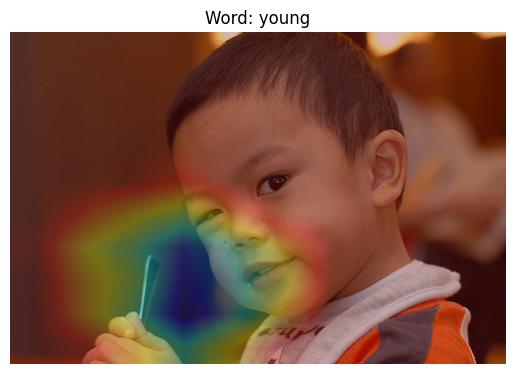

Word: girl


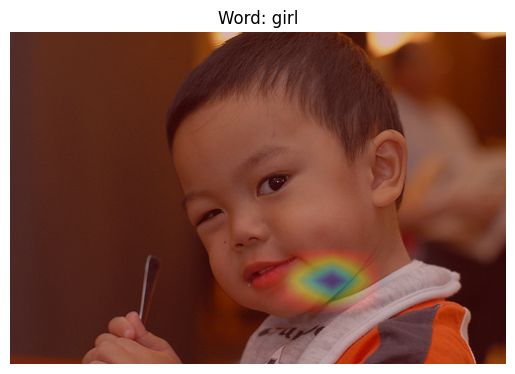

Word: in


<ipython-input-81-69af7f7f0708>:12: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


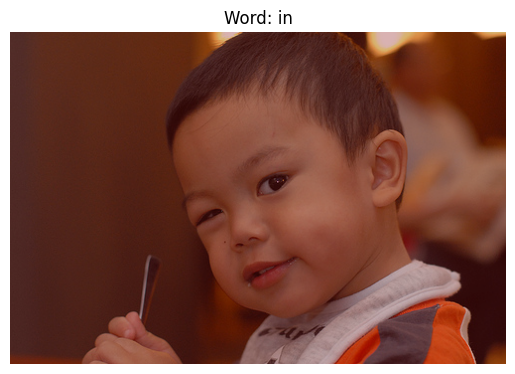

Word: pink


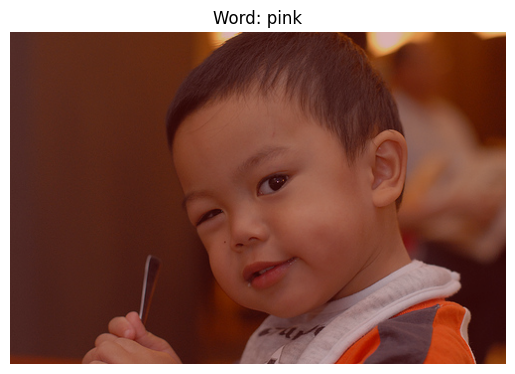

Word: dress


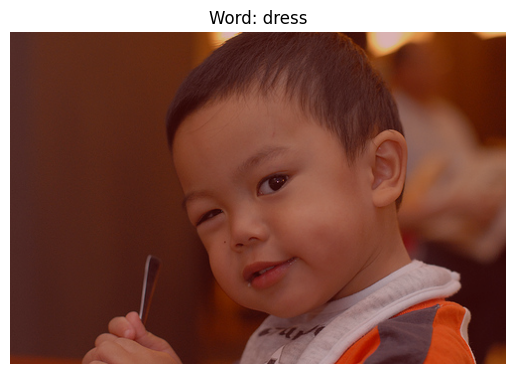

Word: is


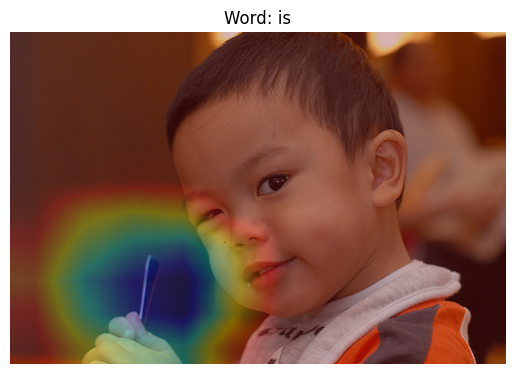

Word: sitting


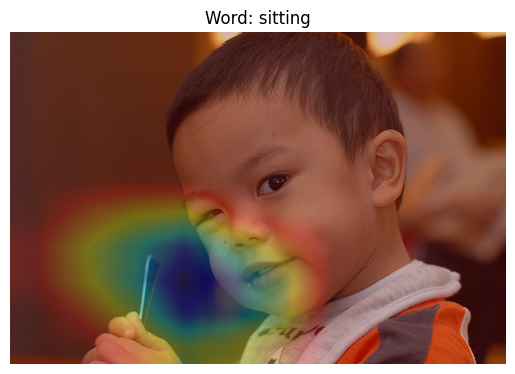

Word: on


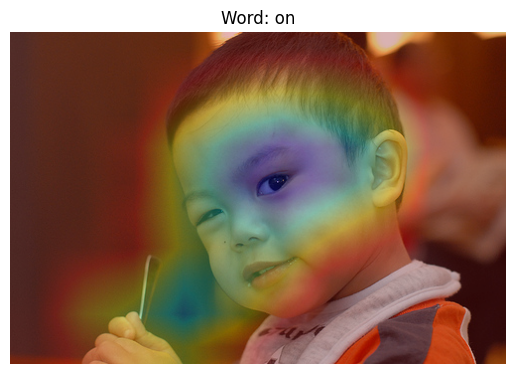

Word: bench


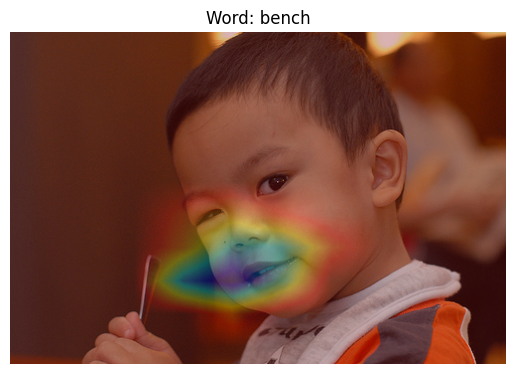

Word: outside


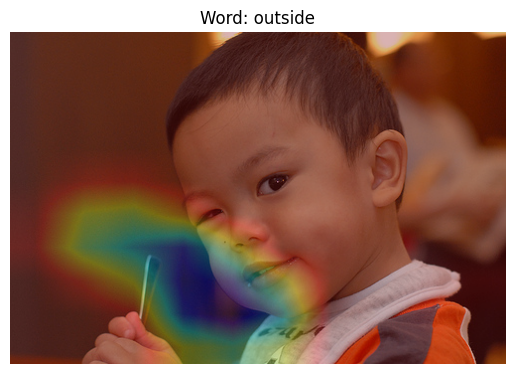

Word: of


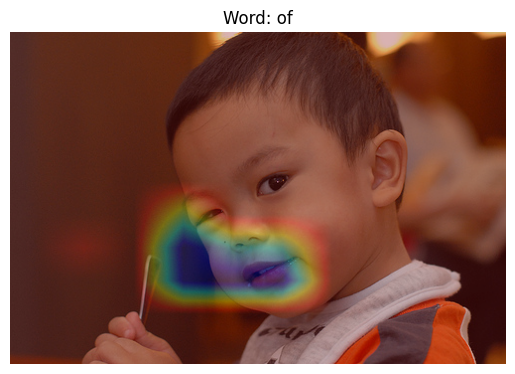

In [ ]:
words = description.split()[1:-1]  # Exclude 'start' and 'end'
for word, heatmap in zip(words, heatmaps):
    print(f"Word: {word}")
    superimposed_img = overlay_heatmap(heatmap, img_path)
    overlay_heatmap_on_word(heatmap, img_path, word)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step

Generated Caption:
start young girl in pink dress is sitting on bench outside of water end


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_308']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


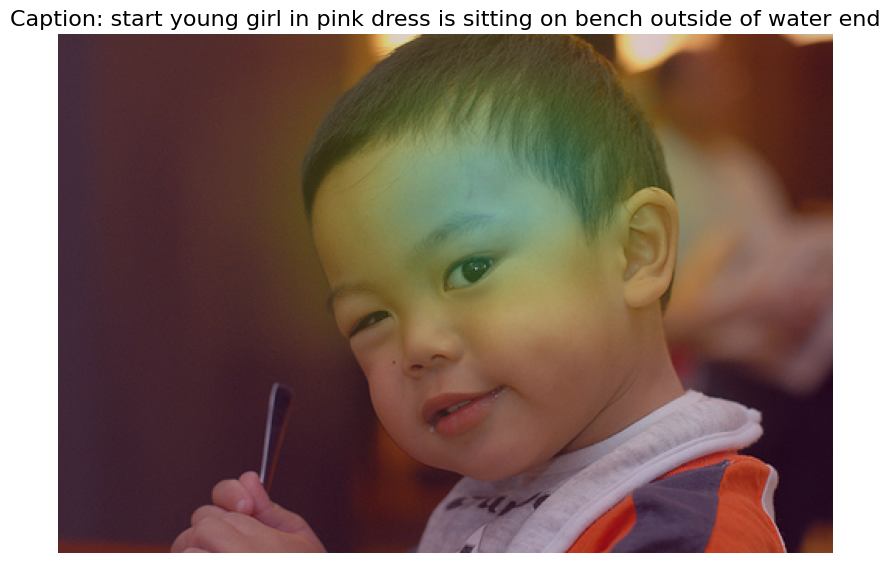

In [ ]:
img_path = "Flicker8k_Dataset/3757598567_739b7da835.jpg"

last_conv_layer_name = 'block14_sepconv2_act'

photo = extract_features(img_path, xception_model)

description = generate_desc(model, tokenizer, photo, max_length)
print("\nGenerated Caption:")
print(description)

img_array = get_img_array(img_path, size=(299, 299))

heatmap = make_gradcam_heatmap(img_array, xception_model, last_conv_layer_name='block14_sepconv2_act')

superimposed_img = overlay_heatmap(heatmap, img_path, alpha=0.3, colormap=cv2.COLORMAP_VIRIDIS)


plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img)
plt.title("Caption: " + description, fontsize=16)
plt.axis('off')
plt.show()
